In [1]:
import os
import sys
import matplotlib
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, cluster
from scipy.cluster.hierarchy import dendrogram
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler, Normalizer
sns.set(style="darkgrid")

In [2]:
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
%matplotlib inline

In [3]:
%run clustering-methods.ipynb

In [4]:
minute_interval = 15
non_reoccuing_number = 100
linkage_methods = ['ward', 'complete', 'average', 'single']
document_features_name = "lifespan"
used_features = ['non-zero-occurances','occurances','non-zero-ratio','above-c95','ar_24','ar_47','lifespan']

In [5]:
ts_data = pd.read_csv(f"../../../data/corrected_m1/corrected_data_{minute_interval}_{non_reoccuing_number}.csv")

In [6]:
ts_data['date'] = pd.to_datetime(ts_data['date'])
ts_data['ndt'] = pd.to_datetime(ts_data.date) + ts_data.hours.astype('timedelta64[h]') + ts_data.minutes.astype('timedelta64[m]')

In [7]:
features = pd.read_csv(f"../../../data/clustering_features/features_{minute_interval}_{non_reoccuing_number}.csv")
features['non-zero-ratio'] = features['non-zero-occurances'] / features['occurances']
features = features.fillna(0)

In [8]:
features_cl = features.drop(columns=['hash'])

In [9]:
global_date_range = pd.date_range(start=ts_data.date.min().date(), end=ts_data.date.max().date())

## Lifespan features

In [13]:
print(used_features)

['non-zero-occurances', 'occurances', 'non-zero-ratio', 'above-c95', 'ar_24', 'ar_47', 'lifespan']


In [29]:
features_reduced = features_cl[used_features]

In [30]:
r_scaler = StandardScaler().fit(features_reduced)
features_reduced_scaled = r_scaler.transform(features_reduced)
r_normalizer = Normalizer().fit(features_reduced_scaled)
features_rsn = pd.DataFrame(r_normalizer.transform(features_reduced_scaled))
features_rsn.columns = used_features

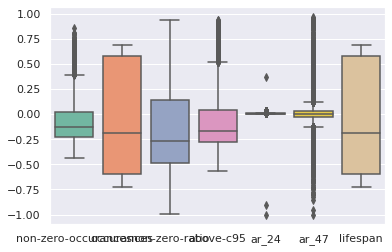

In [16]:
sns.boxplot(data=features_rsn, palette="Set2")

## Method dendograms

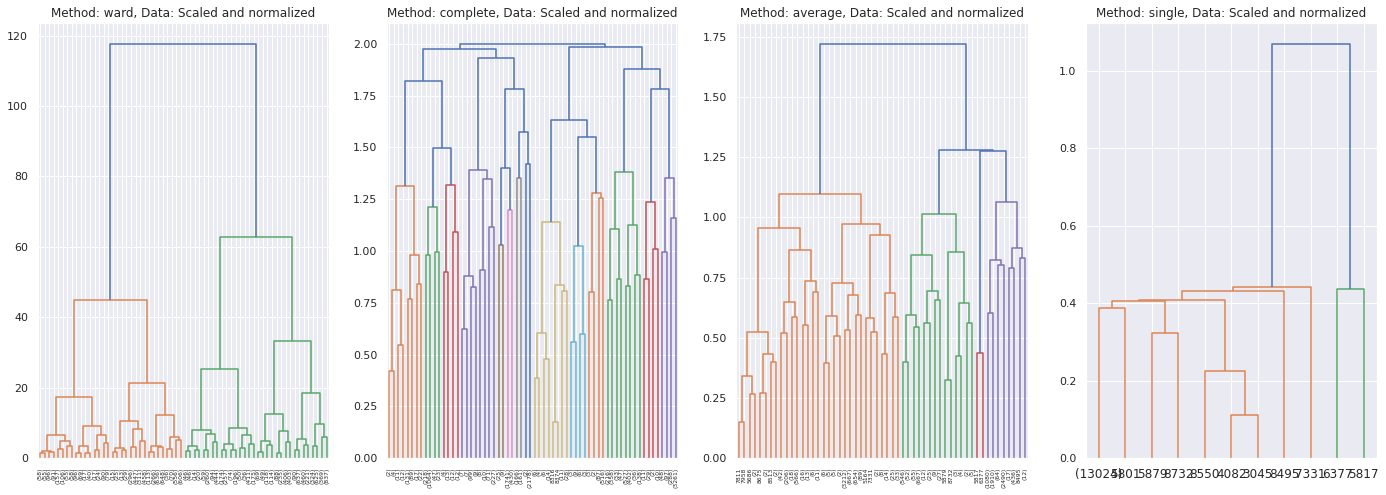

In [15]:
fig, ax = plt.subplots(1, len(linkage_methods))
fig.set_size_inches(24, 8)
for i, method in enumerate(linkage_methods):
    fitted_model = fit_model(features_rsn, method)
    model_dendogram(fitted_model, 5, ax=ax[i])
    ax[i].set_title(f'Method: {method}, Data: Scaled and normalized')

## Single linkage

In [16]:
model_single_rsn = fit_model(features_rsn, 'single', 12, None)
clusters_single_rsn = model_single_rsn.fit_predict(features_rsn)
print(cluster_sizes(clusters_single_rsn))

[13019     2     2     1     1     1     3     1     1     1     1     1]


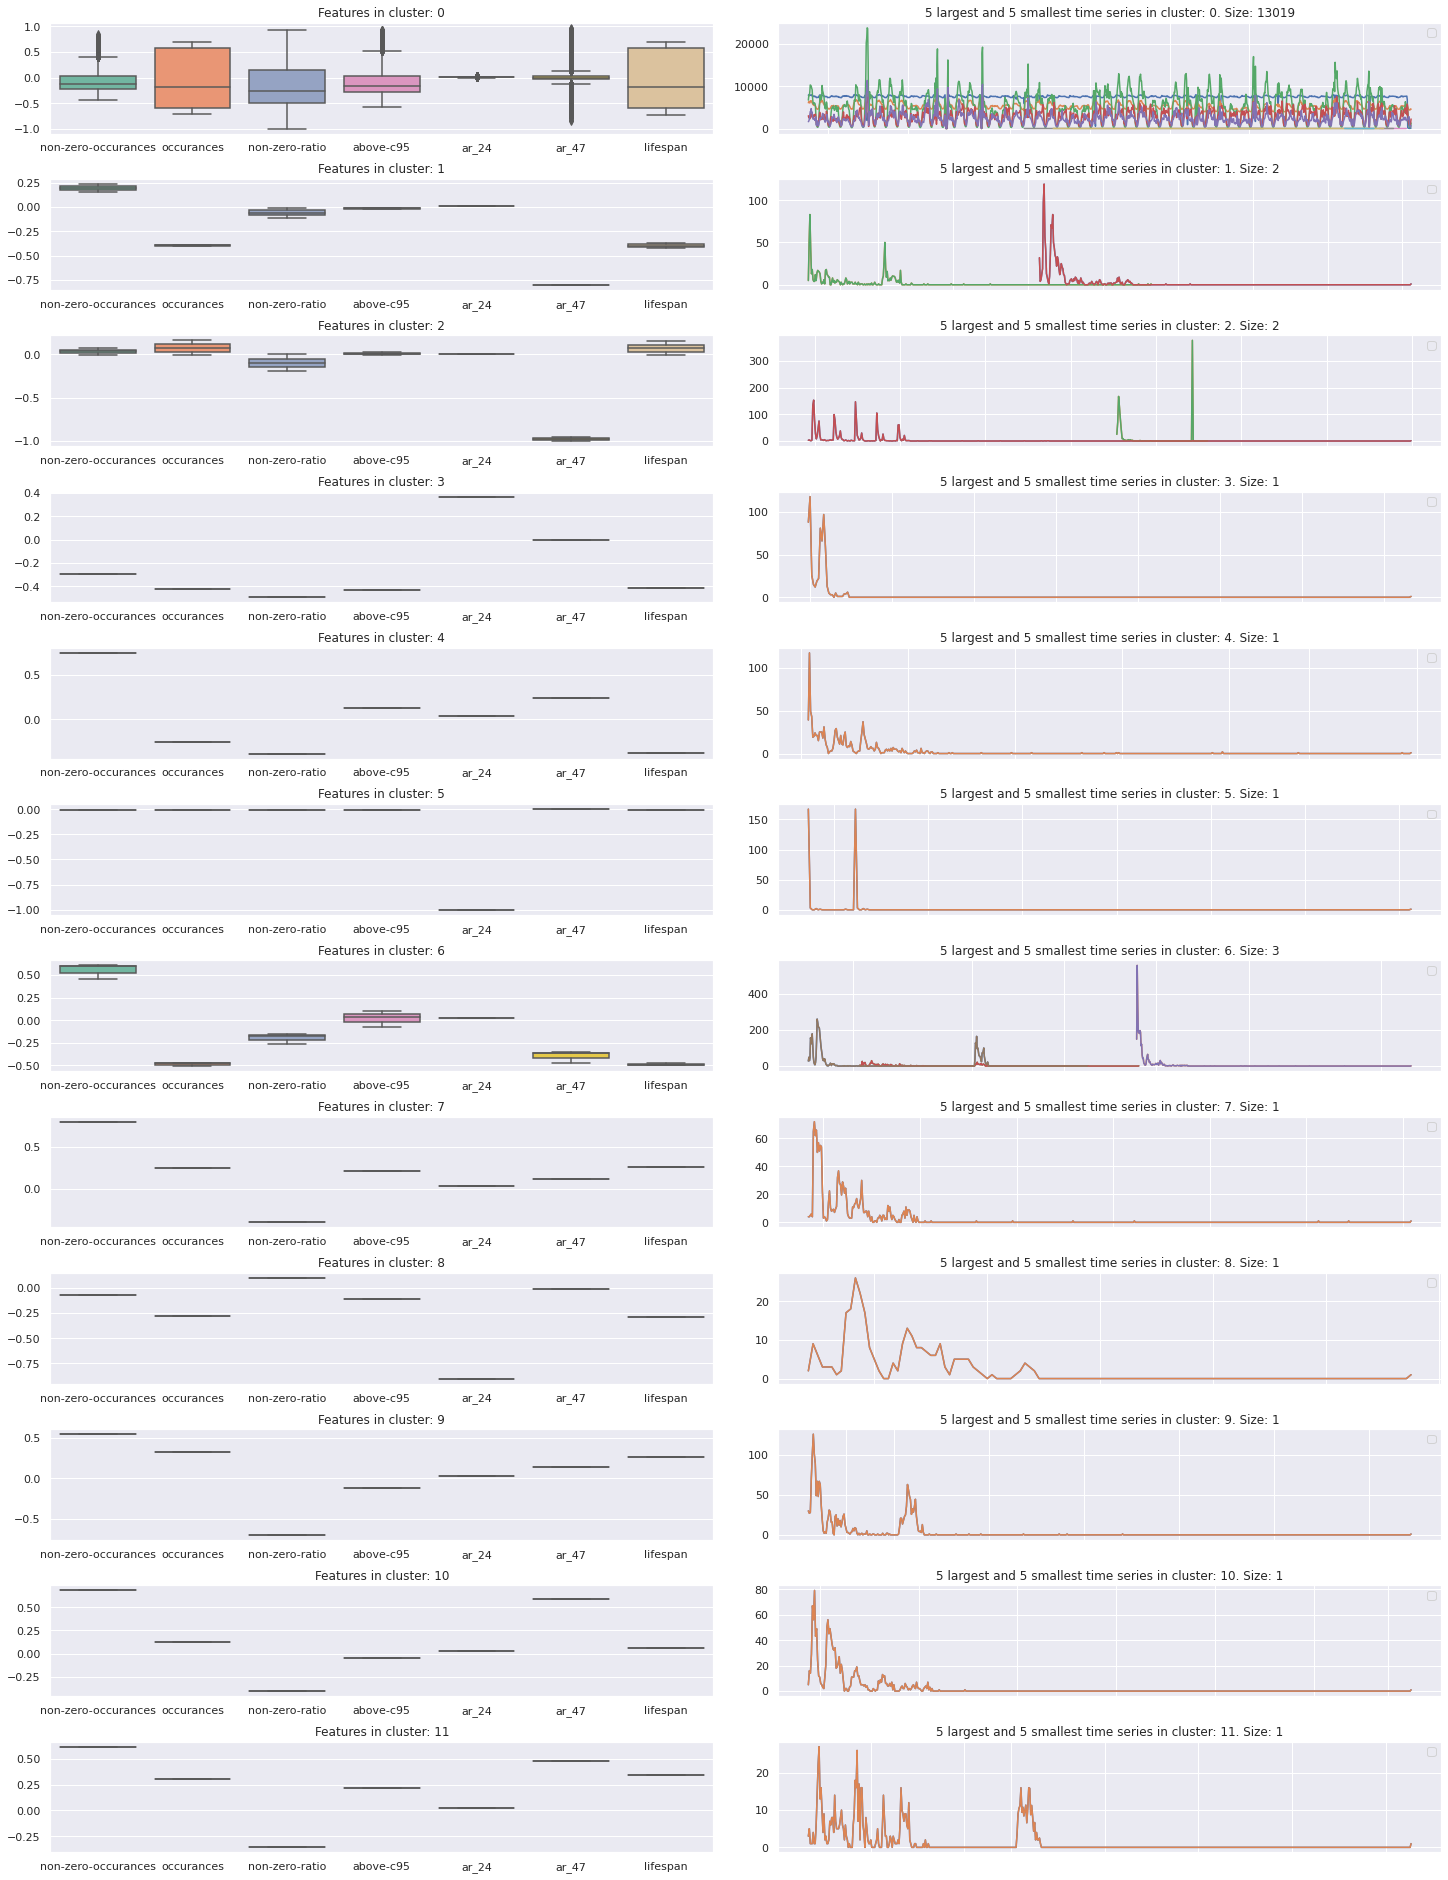

In [17]:
plot_cluster_comparison(ts_data, features_rsn, features, clusters_single_rsn, w=20, h=26, boxplot_drop=[])

## Average linkage

In [17]:
model_average_rsn = fit_model(features_rsn, 'average', 12, None)
clusters_average_rsn = model_average_rsn.fit_predict(features_rsn)
print(cluster_sizes(clusters_average_rsn))

[  16   13 1393 4640  453 5544   80    2   11    4   46  832]


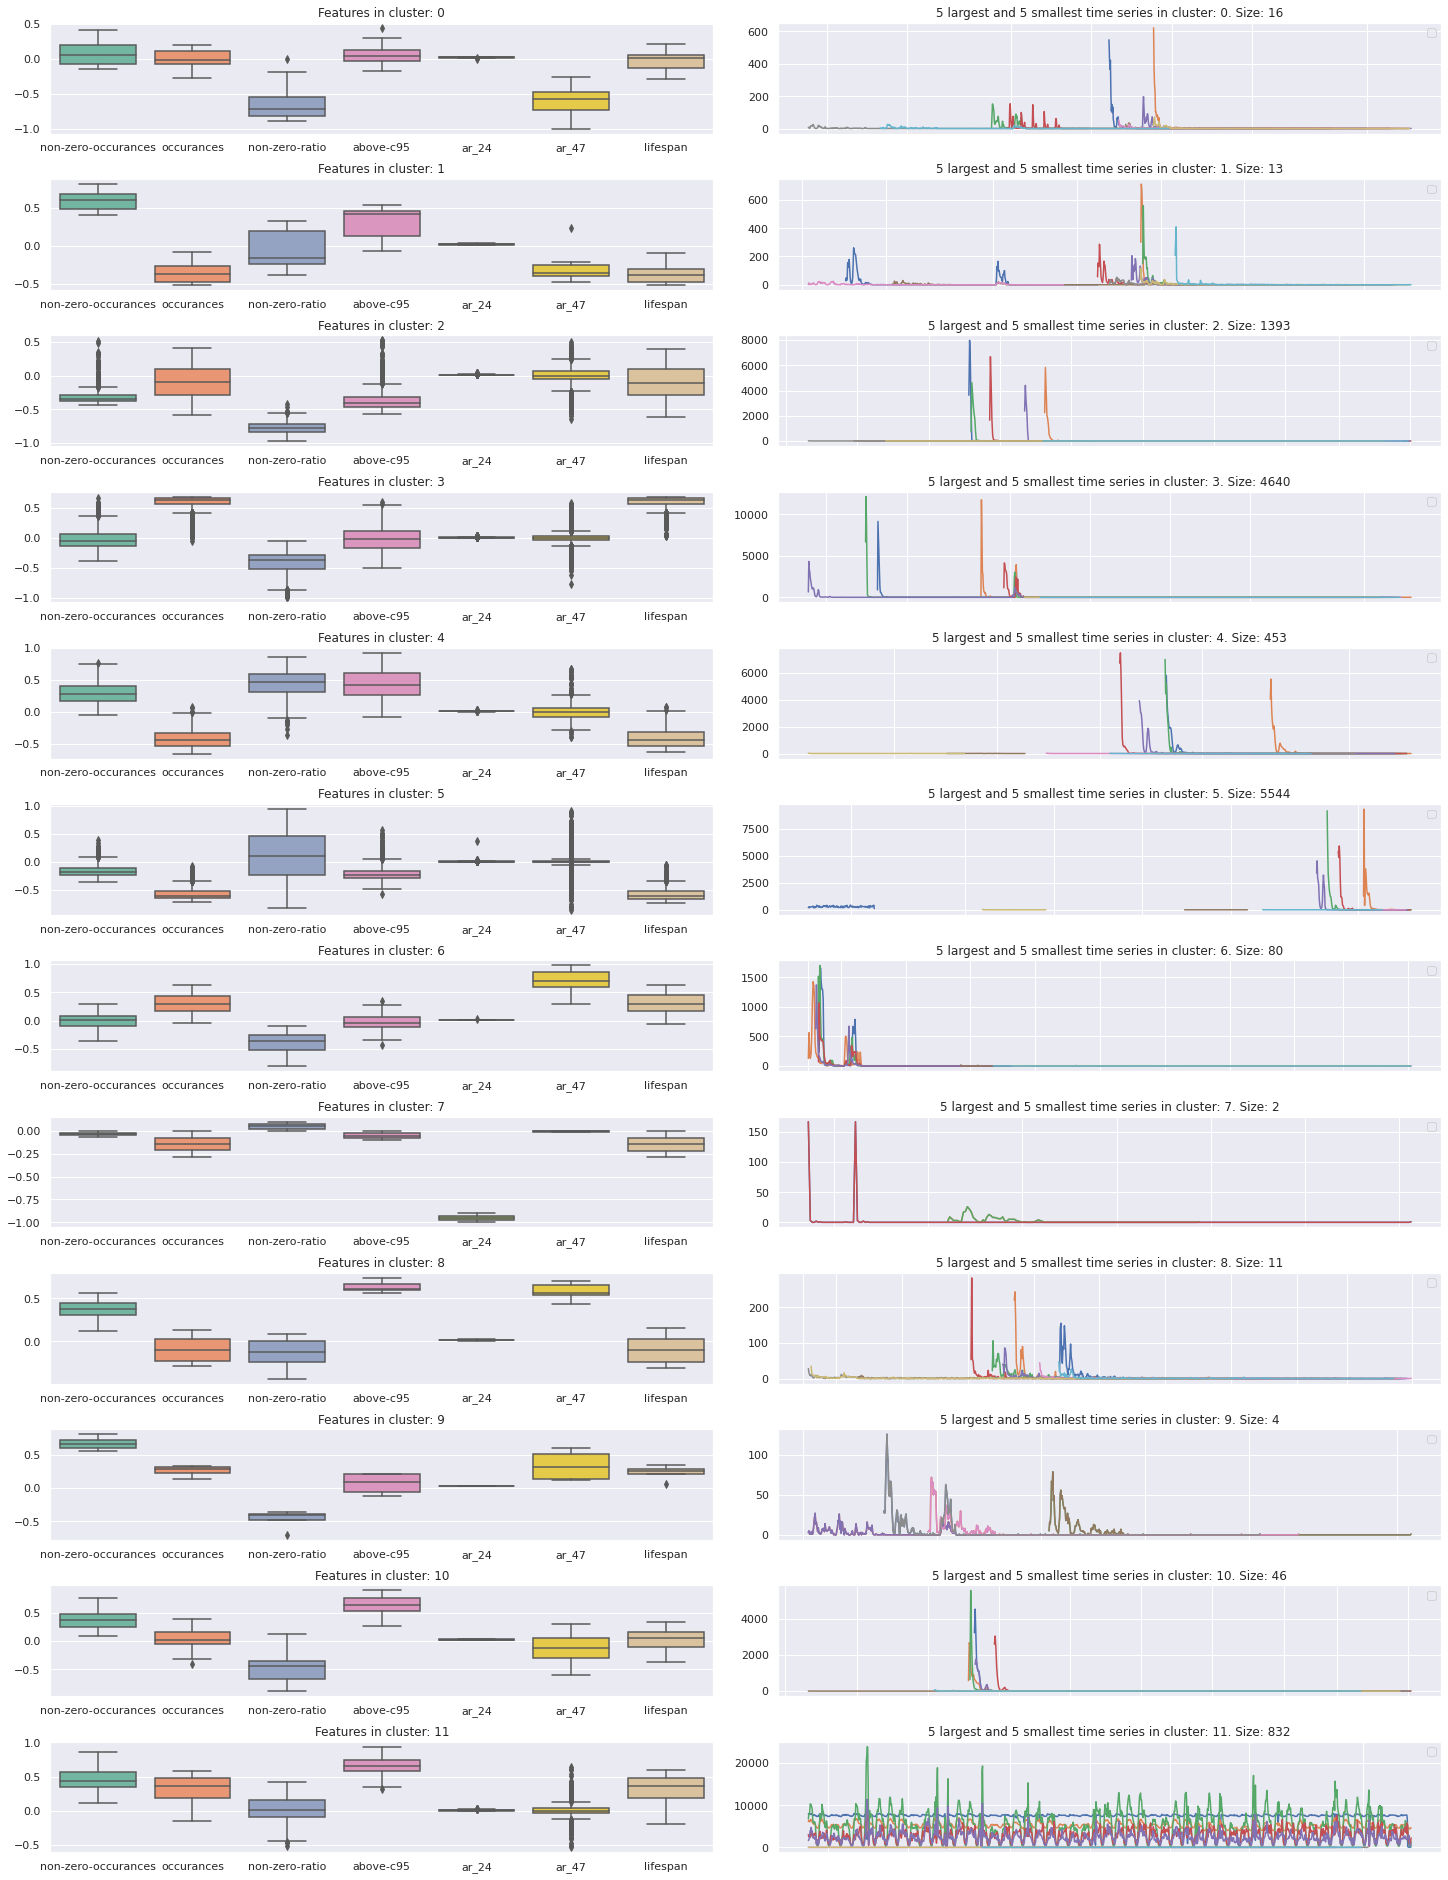

In [19]:
plot_cluster_comparison(ts_data, features_rsn, features, clusters_average_rsn, w=20, h=26, boxplot_drop=[])

## Complete linkage

In [23]:
model_complete_rsn = fit_model(features_rsn, 'complete', 12, None)
clusters_complete_rsn = model_complete_rsn.fit_predict(features_rsn)
print(cluster_sizes(clusters_complete_rsn))

[1393 2180 1757 2205  438 3694  288  608   52   71  327   21]


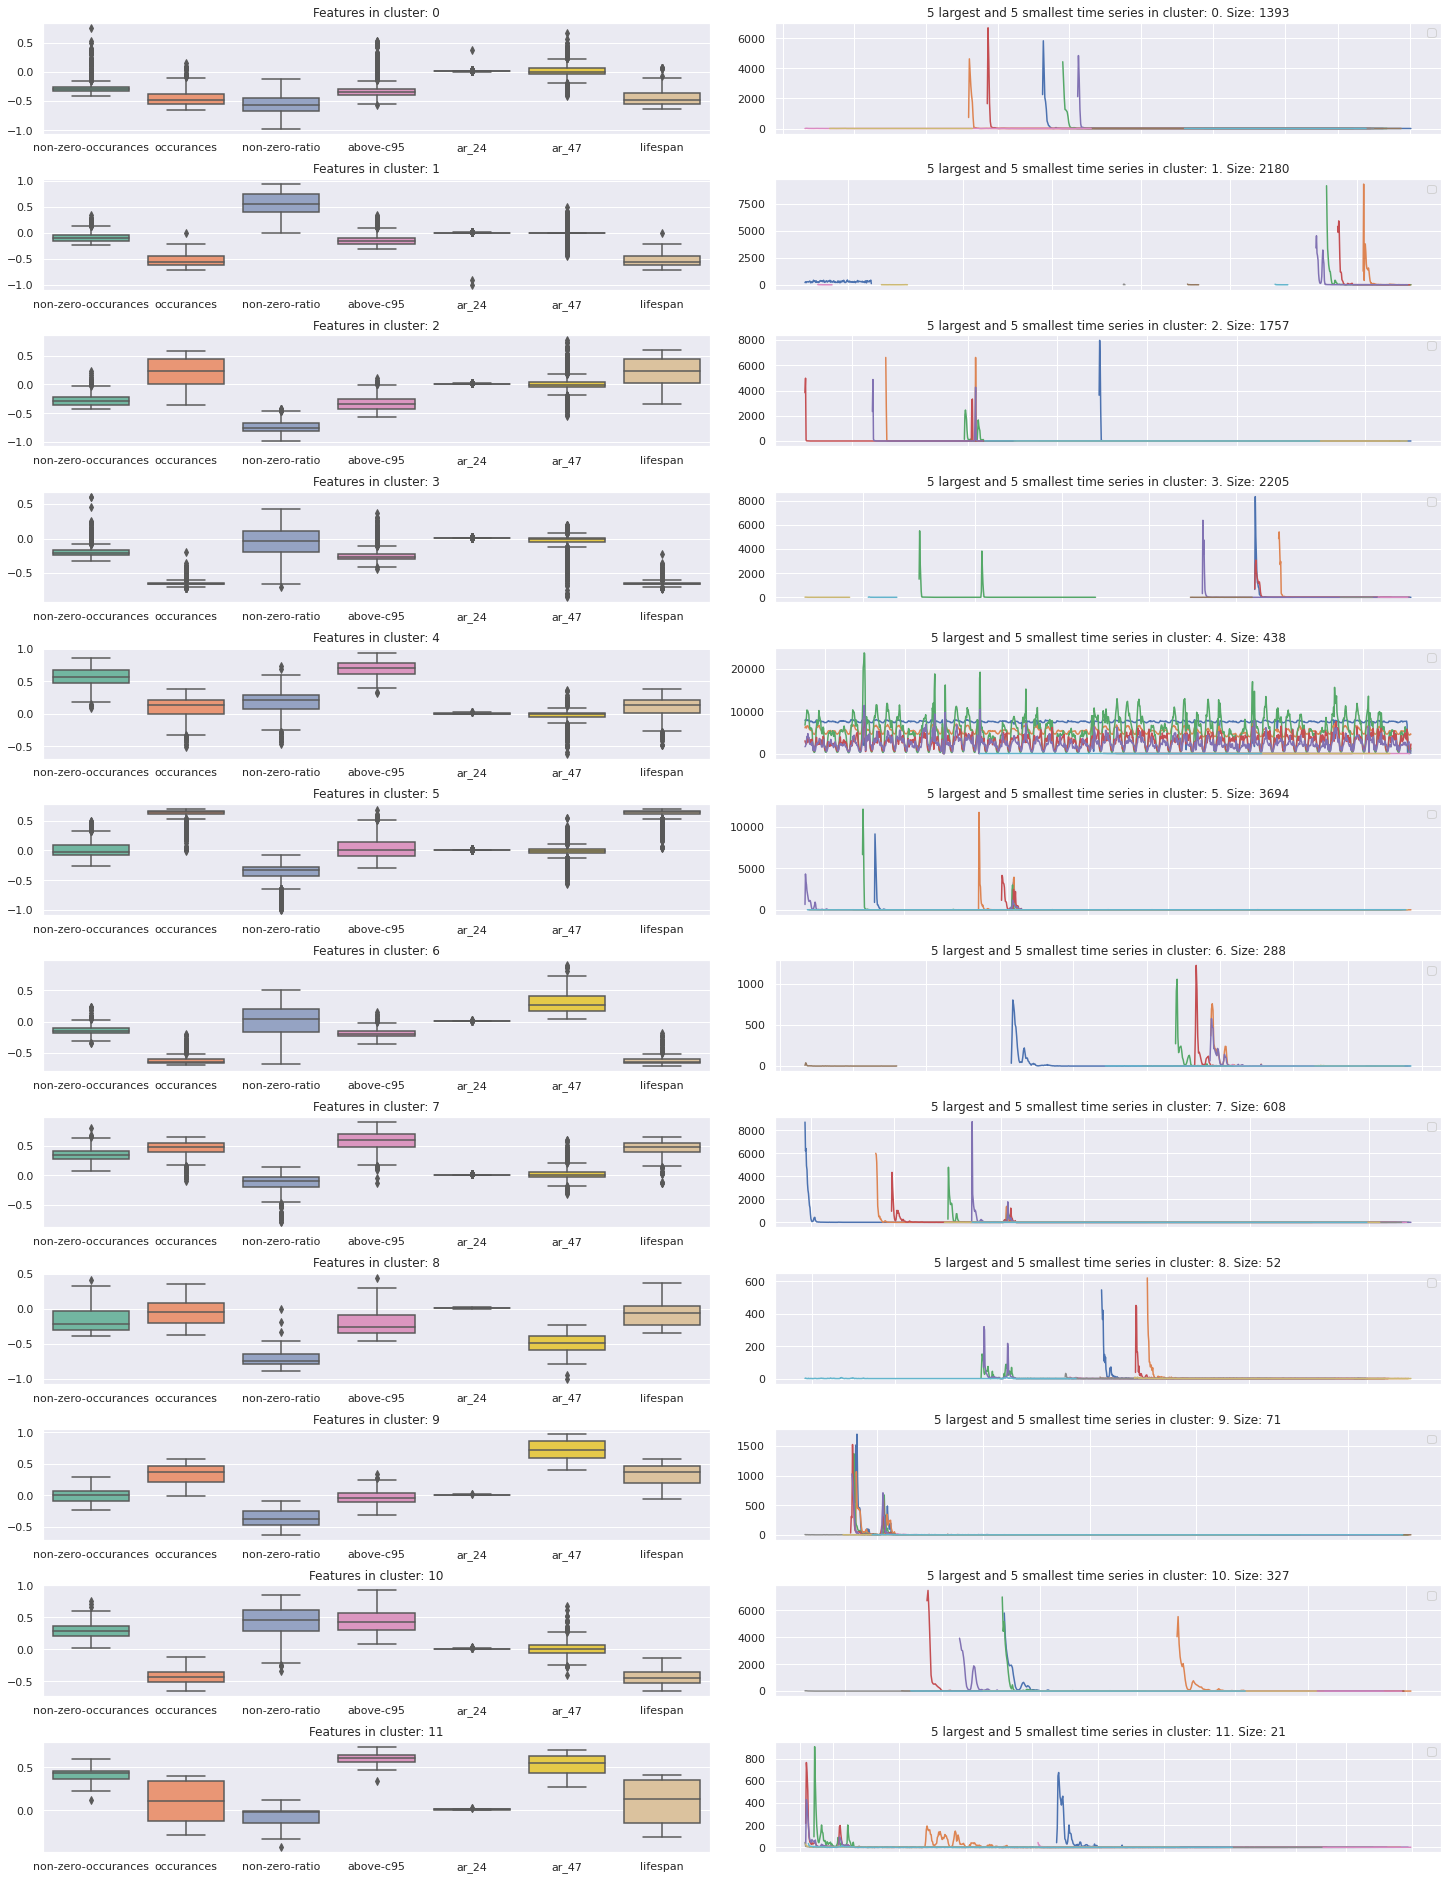

In [24]:
plot_cluster_comparison(ts_data, features_rsn, features, clusters_complete_rsn, w=20, h=26, boxplot_drop=[])

## Ward linkage

In [14]:
model_ward_rsn = fit_model(features_rsn, 'ward', 12, None)
clusters_ward_rsn = model_ward_rsn.fit_predict(features_rsn)
print(cluster_sizes(clusters_ward_rsn))

[2155  432  983 1373 1512 1268 1132 1408  676  350 1663   82]


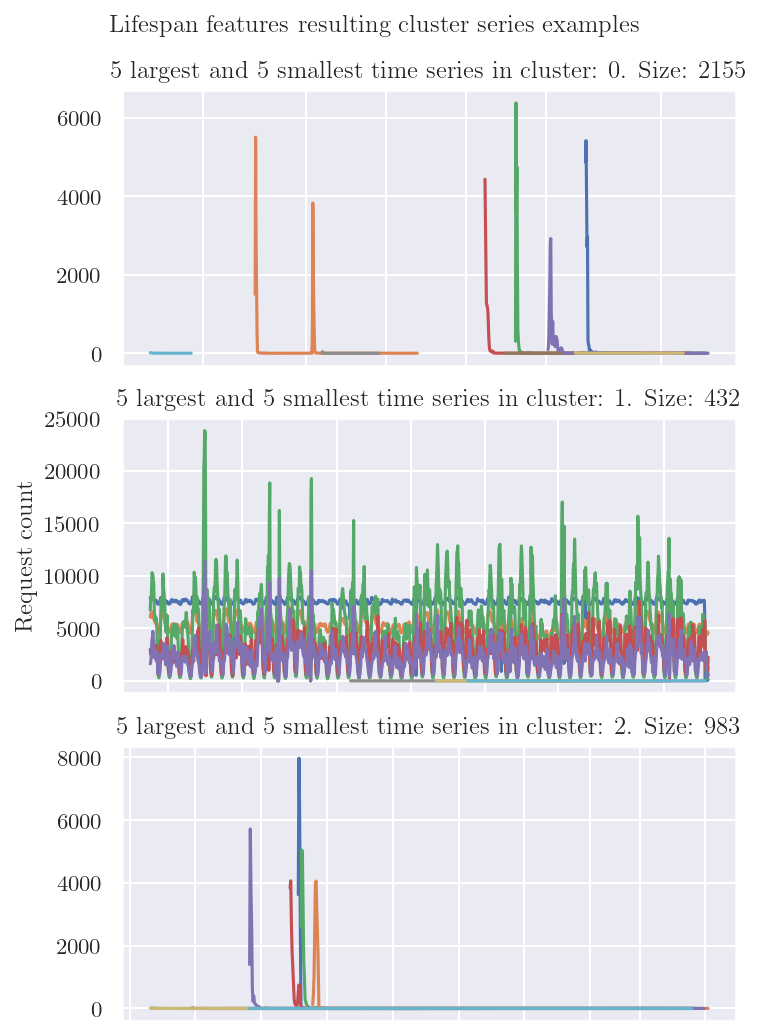

In [43]:
fig, ax = plt.subplots(3, 1, dpi=150, tight_layout=True)
fig.set_size_inches(w=5.10686, h=7)
fig.suptitle("Lifespan features resulting cluster series examples")

plot_cluster_ts(ts_data, features, clusters_ward_rsn, 0,ax[0])
plot_cluster_ts(ts_data, features, clusters_ward_rsn, 1,ax[1])
plot_cluster_ts(ts_data, features, clusters_ward_rsn, 2,ax[2])
ax[1].set_ylabel("Request count")
ax[0].get_legend().remove()
ax[1].get_legend().remove()
ax[2].get_legend().remove()


fig.savefig('../../../plots/text-plots/4-clustering-review-lifespan-ward-rsn.pgf')

In [ ]:
plot_cluster_comparison_pdf(ts_data, features_rsn, features, clusters_ward_rsn, "../../../plots/text-plots/4-clustering-review-lifespan-ward-rsn.pgf", limit=4, w=5.10686, h=3.5, boxplot_drop=[])

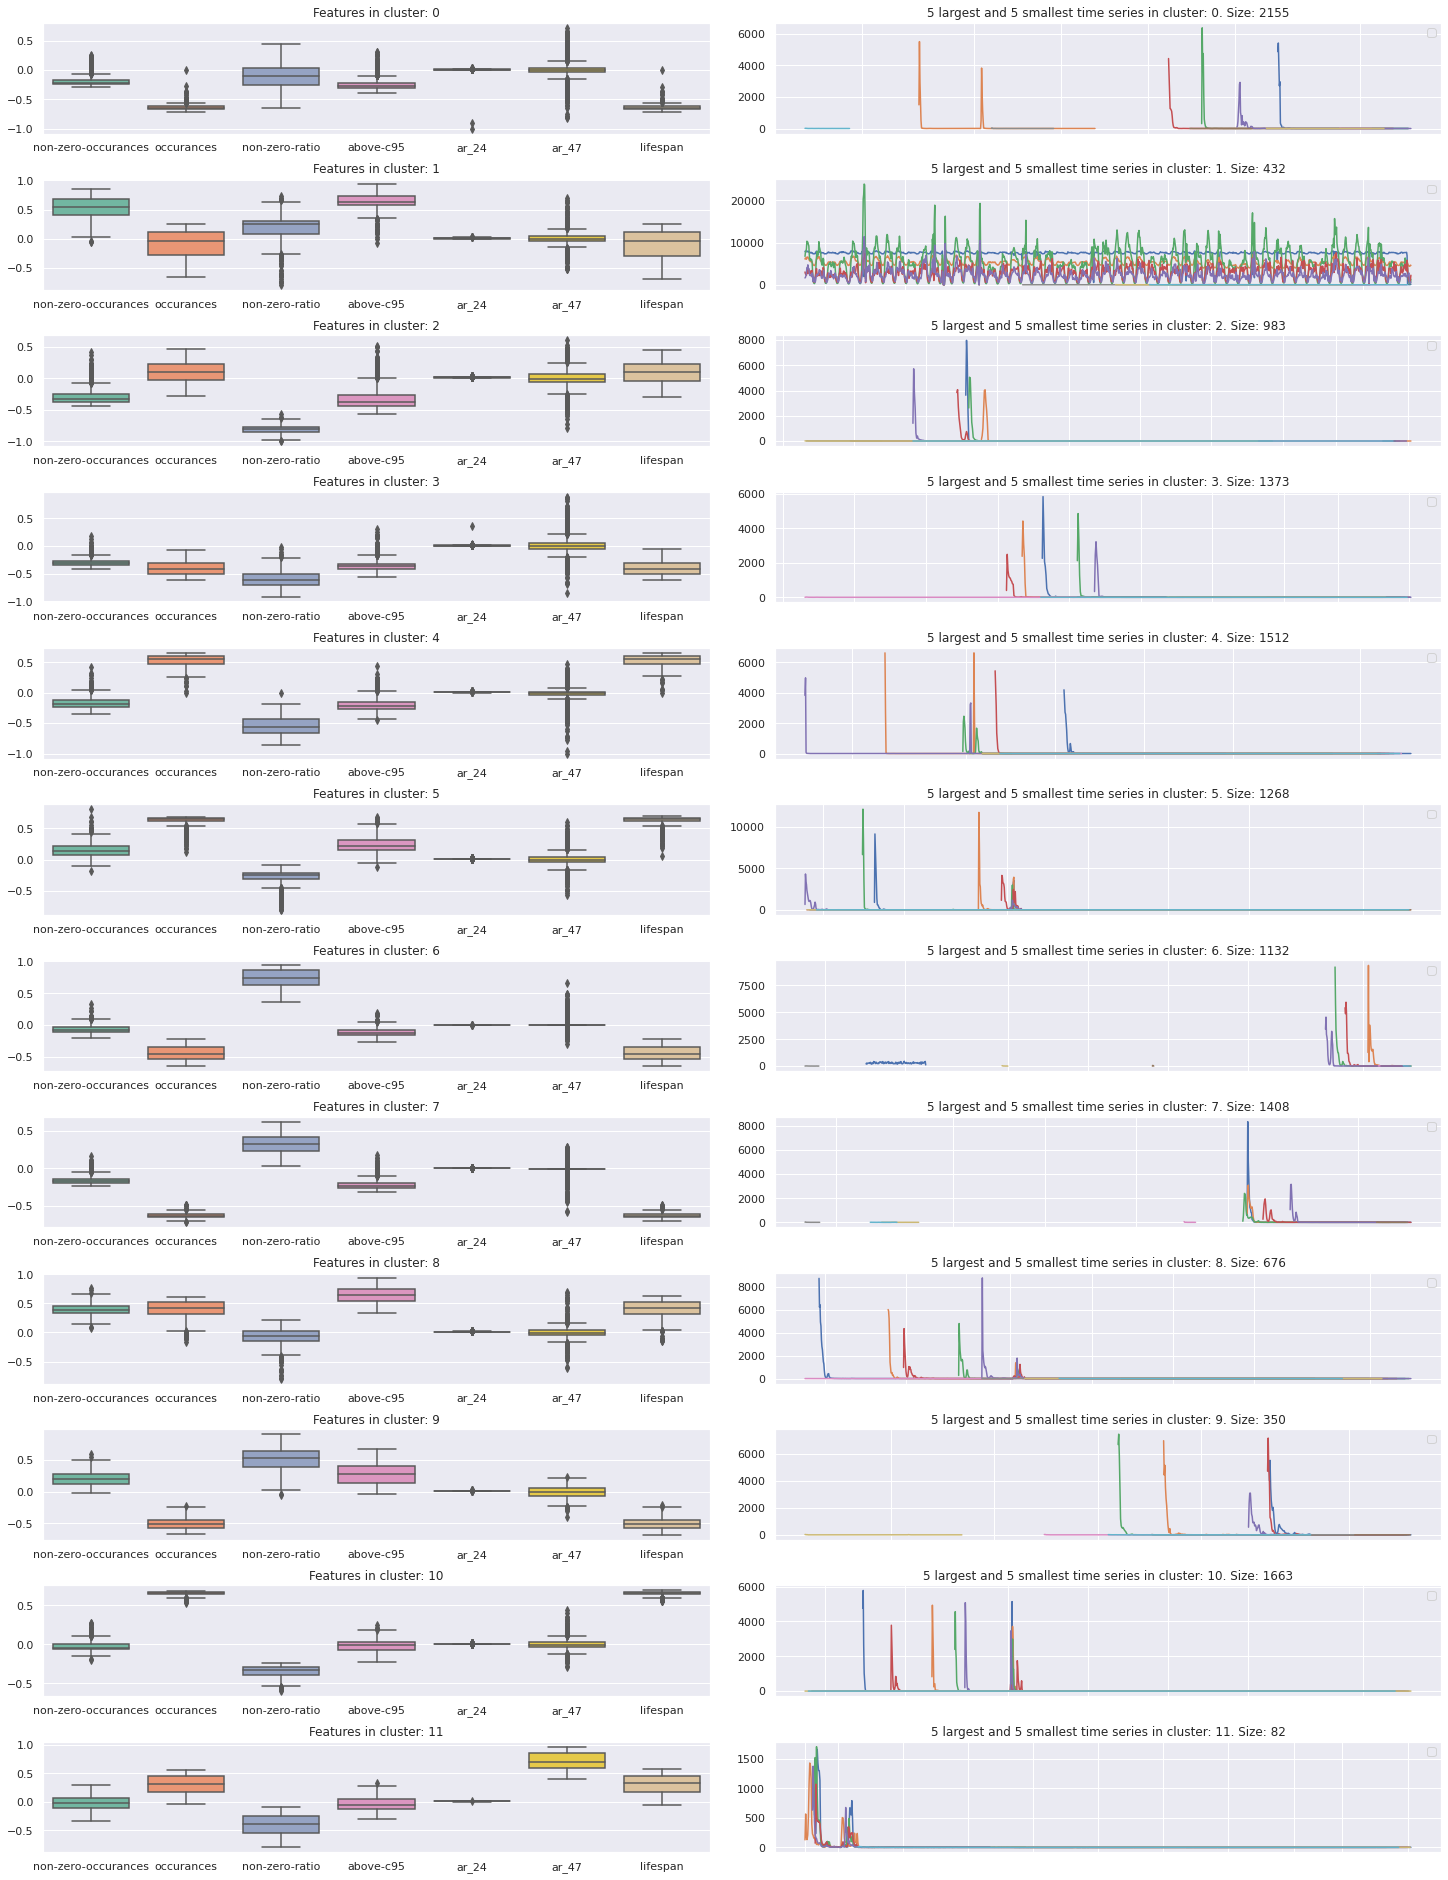

In [23]:
plot_cluster_comparison(ts_data, features_rsn, features, clusters_ward_rsn, w=20, h=26, boxplot_drop=[])

## Evaluation

In [24]:
# Single, average, complete, ward
features['rsn_s'] = clusters_single_rsn
features['rsn_a'] = clusters_average_rsn
features['rsn_c'] = clusters_complete_rsn
features['rsn_w'] = clusters_ward_rsn

In [25]:
cluster_evaluation = []
cluster_evaluation_data = []
cluster_group = 'rsn_c'
n_clusters = 12

In [26]:
for cluster_id in range(0, n_clusters):
    group = pd.DataFrame(features.query(f'{cluster_group} == "{cluster_id}"'))
    cluster_evaluation.append(group)
    cluster_evaluation_data.append(ts_data[ts_data['hash'].isin(group['hash'])])

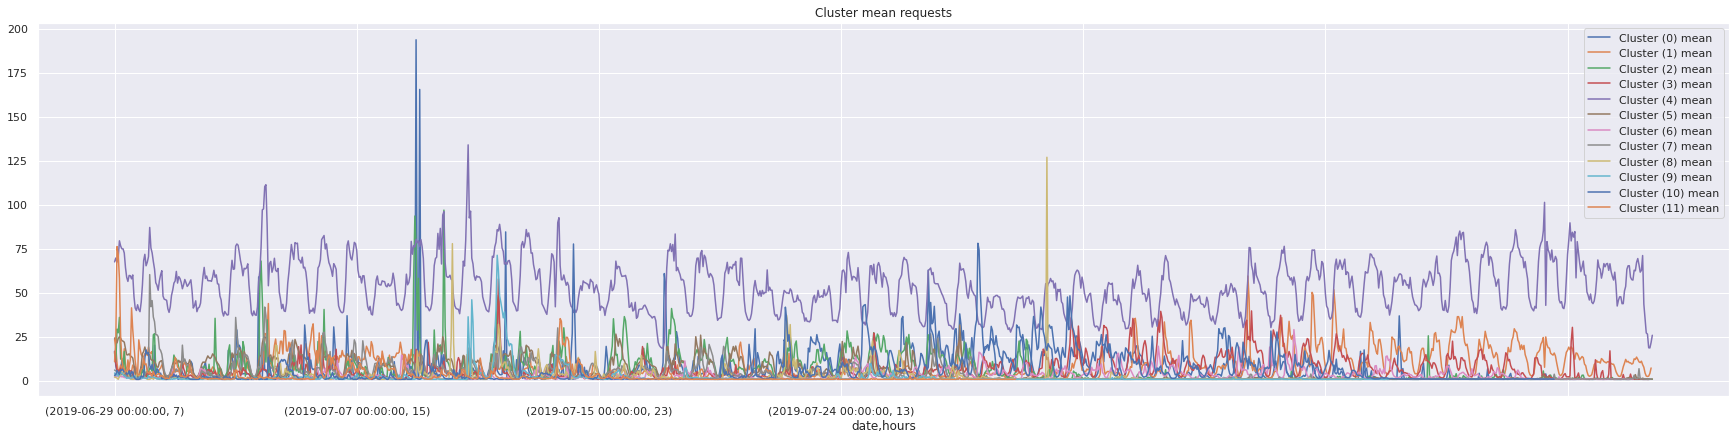

In [27]:
fig, ax = plt.subplots(constrained_layout=True)
fig.set_size_inches(24, 6)
for cluster_id in range(0, n_clusters):
    cluster_evaluation_data[cluster_id].groupby(['date','hours'])['count'].mean().plot(ax=ax, label=f"Cluster ({cluster_id}) mean")
ax.set_title("Cluster mean requests")
ax.legend()

In [28]:
barplot_cluster_lf = pd.DataFrame()
for cluster_id in range(0, n_clusters):
    barplot_cluster_lf[f'Cluster {cluster_id}'] = cluster_evaluation[cluster_id]['lifespan'].value_counts().sort_index().reindex(range(0, max(features['lifespan'].unique())), fill_value=0)

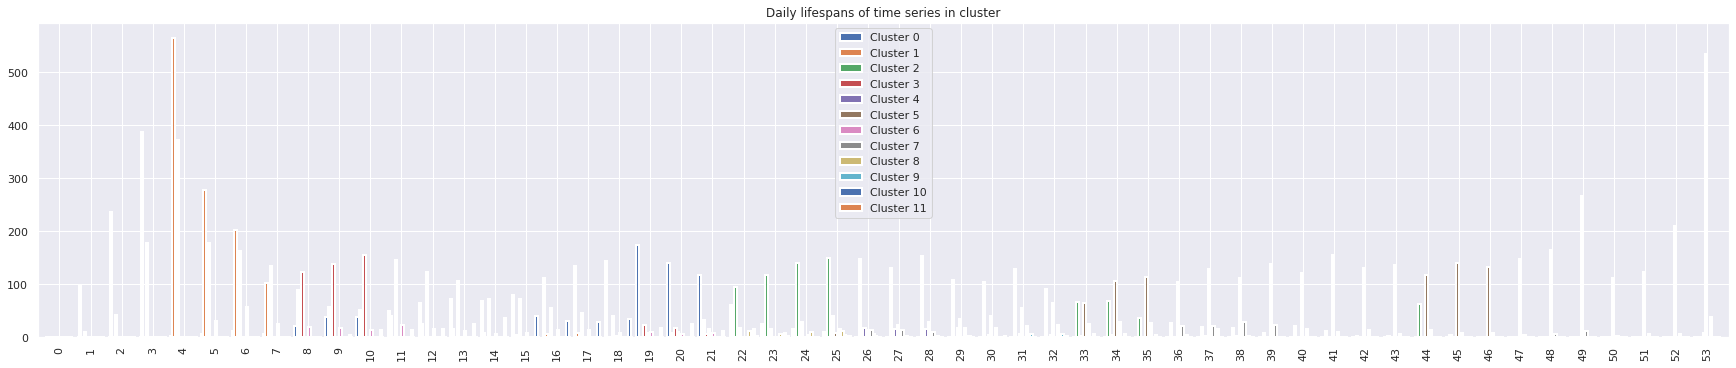

In [29]:
fig, ax = plt.subplots(constrained_layout=True)
fig.set_size_inches(24, 5)
ax.set_title("Daily lifespans of time series in cluster")
barplot_cluster_lf.plot(kind='bar',ax=ax, width=0.9, linewidth=2) #color=['r','b']
ax.legend()

In [30]:
ts_group = ts_data.drop(columns=['hours','minutes']).groupby(['hash','ndt']).sum()

In [31]:
# Disabled to prevent filling RAM
#for cluster_id in range(0, n_clusters):
#    plot_path = f"../../../plots/{document_features_name}/{cluster_group}-c{cluster_id}"
#    os.makedirs(plot_path)
#    plot_cluster(cluster_id, ts_group, cluster_evaluation[cluster_id].sort_values('sum'), plot_path)

In [32]:
#!tar -czf ../../plots/c0.tar ../../plots/
#!tar -czf ../../plots/c1.tar ../../plots/c1

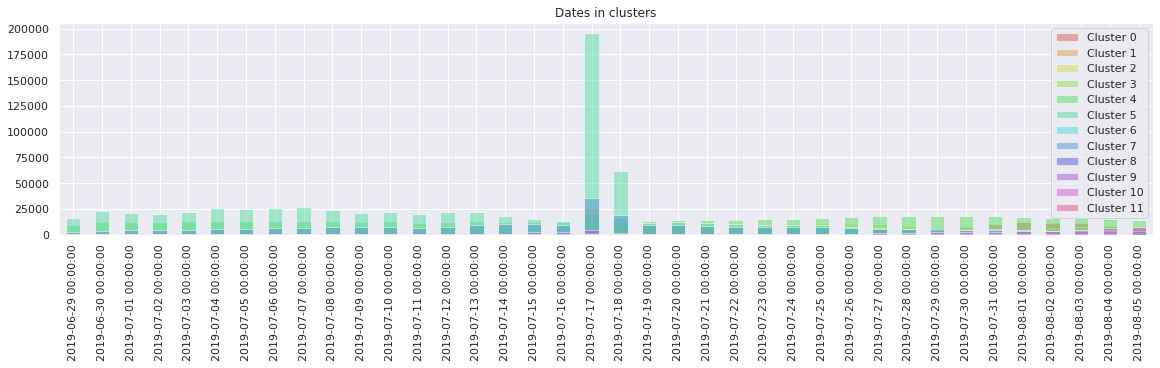

In [33]:
fig, ax = plt.subplots(constrained_layout=True)
fig.set_size_inches(16, 5)
ax.set_title("Dates in clusters")
for cluster_id in range(0, n_clusters):
    ts_data[ts_data['hash'].isin(cluster_evaluation[cluster_id]['hash'])]['date'].value_counts().sort_index()\
                           .plot(kind='bar', alpha=0.5, color=sns.color_palette("hls", n_clusters)[cluster_id], ax=ax, label=f'Cluster {cluster_id}')
ax.legend()